In [1]:
import numpy as np
import sklearn as sk
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import pandas as pd

In [2]:
#Set the default figure size for the notebook, so they are not all tiny
matplotlib.rcParams['figure.figsize'] = (12,8)

In [3]:
import rpy2
%load_ext rpy2.ipython

In [4]:
%%R -o spam

load("spam.RData")
colnames(spam)[1:57] <- c("word_freq_make", "word_freq_address", "word_freq_all", "word_freq_3d", "word_freq_our", "word_freq_over", "word_freq_remove", "word_freq_internet", "word_freq_order", "word_freq_mail", "word_freq_receive", "word_freq_will", "word_freq_people", "word_freq_report", "word_freq_addresses", "word_freq_free", "word_freq_business", "word_freq_email", "word_freq_you", "word_freq_credit", "word_freq_your", "word_freq_font", "word_freq_000", "word_freq_money", "word_freq_hp", "word_freq_hpl", "word_freq_george", "word_freq_650", "word_freq_lab", "word_freq_labs", "word_freq_telnet", "word_freq_857", "word_freq_data", "word_freq_415", "word_freq_85", "word_freq_technology", "word_freq_1999", "word_freq_parts", "word_freq_pm", "word_freq_direct", "word_freq_cs", "word_freq_meeting", "word_freq_original", "word_freq_project", "word_freq_re", "word_freq_edu", "word_freq_table", "word_freq_conference", "char_freq_semicol", "char_freq_paren", "char_freq_bracket", "char_freq_exc", "char_freq_dollar", "char_freq_pound", "capital_run_length_average", "capital_run_length_longest", "capital_run_length_total")


In [5]:
print(spam.shape)
spam.head()

(4601, 58)


,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_semicol,char_freq_paren,char_freq_bracket,char_freq_exc,char_freq_dollar,char_freq_pound,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
1,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,spam
2,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,spam
3,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,spam
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,spam
5,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,spam


In [6]:
X = spam.iloc[:,0:57]
y = np.where(spam['spam'] == 'spam', 1, 0)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [9]:
# The sklearn version of logistic regression automatically has a ridge penalty
# Large C means small penalty here (opposite of lambda)
lmfit = LogisticRegression(C=1000000, solver='liblinear').fit(X_train, y_train)

yhat_lm = lmfit.predict(X_test)
np.mean(y_test != yhat_lm)


0.07307439104674128

In [10]:
from sklearn.linear_model import LogisticRegressionCV
lassofit = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=50).fit(X_train, y_train)
yhat_lasso = lassofit.predict(X_test)
np.mean(y_test != yhat_lasso)


0.07570770243581304

How about trees?

In [11]:
from sklearn.tree import DecisionTreeClassifier
treefit = DecisionTreeClassifier(random_state=0).fit(X_train,y_train)
yhat_tree = treefit.predict(X_test)
np.mean(yhat_tree != y_test)

0.09084924292297564

In [12]:
from sklearn.tree import DecisionTreeClassifier
treefit = DecisionTreeClassifier(min_samples_leaf=200).fit(X_train,y_train)
yhat_tree = treefit.predict(X_test)
np.mean(yhat_tree != y_test)

0.14351547070441079

In [13]:
from sklearn.tree import DecisionTreeClassifier
treefit = DecisionTreeClassifier(min_samples_leaf=20).fit(X_train,y_train)
yhat_tree = treefit.predict(X_test)
np.mean(yhat_tree != y_test)

0.10138248847926268

In [15]:
import graphviz
from sklearn.tree import export_graphviz

In [ ]:
dot_data = export_graphviz(treefit, out_file=None)
graph = graphviz.Source(dot_data)
graph

# What happens if we do pruning in R?

[1] 0.08689928


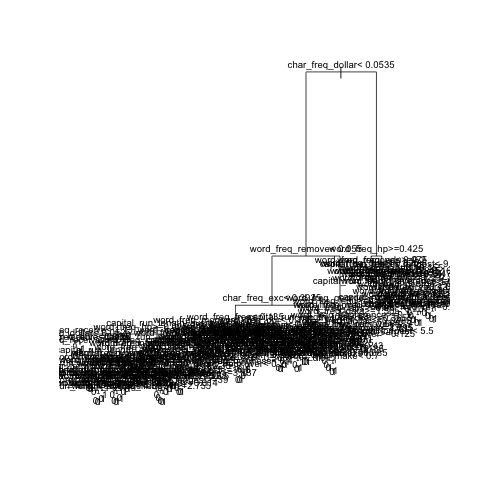

In [17]:
%%R -i X_train -i X_test -i y_train -i y_test

# You can also use the library "tree", but it is not as nice
library(rpart)
dat_train = cbind(as.factor(y_train),X_train)
dat_test = cbind(as.factor(y_test),X_test)
names(dat_train)[1] = 'y'
names(dat_test)[1] = 'y'

# Note: I'm overriding the control parameters so you can see a bigger tree.
# In reality, the defaults are a smarter bet.
tree = rpart(y~., data=dat_train, control=rpart.control(cp=0.0001, minbucket=1))

yhat1 = predict(tree, dat_test, type='class')
print(mean(yhat1 != y_test))

plot(tree)
text(tree, pretty=0, cex=0.8)


In [18]:
%%R

printcp(tree)


Classification tree:
rpart(formula = y ~ ., data = dat_train, control = rpart.control(cp = 1e-04, 
    minbucket = 1))

Variables actually used in tree construction:
 [1] capital_run_length_average capital_run_length_longest
 [3] capital_run_length_total   char_freq_bracket         
 [5] char_freq_dollar           char_freq_exc             
 [7] char_freq_paren            word_freq_000             
 [9] word_freq_1999             word_freq_650             
[11] word_freq_address          word_freq_addresses       
[13] word_freq_all              word_freq_business        
[15] word_freq_conference       word_freq_credit          
[17] word_freq_data             word_freq_edu             
[19] word_freq_email            word_freq_font            
[21] word_freq_free             word_freq_george          
[23] word_freq_hp               word_freq_hpl             
[25] word_freq_internet         word_freq_labs            
[27] word_freq_mail             word_freq_make            
[29] wo

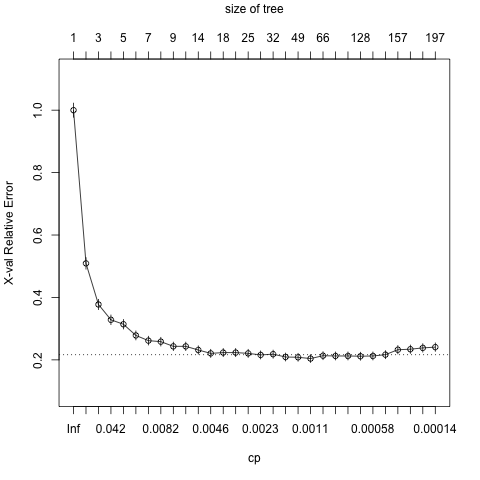

In [19]:
%%R

plotcp(tree)

In [20]:
%%R

mincp = tree$cptable[which.min(tree$cptable[,"xerror"]), "CP"]

mincp

[1] 0.0009259259


[1] 0.08492429


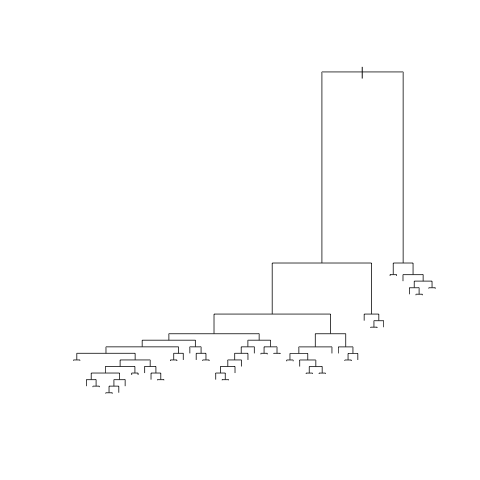

In [21]:
%%R

tree_pruned = prune(tree, cp = mincp)

plot(tree_pruned)
#text(tree_pruned)
yhat1 = predict(tree_pruned, dat_test, type='class')
print(mean(yhat1 != y_test))


# Finally, let's look at random forests

In [22]:
from sklearn.ensemble import RandomForestClassifier

In [23]:
fitrf = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=1).fit(X_train, y_train)

In [24]:
yhat_rf = fitrf.predict(X_test)
np.mean(yhat_rf != y_test)

0.040157998683344305

In [25]:
1-fitrf.oob_score_

0.053212199870214194

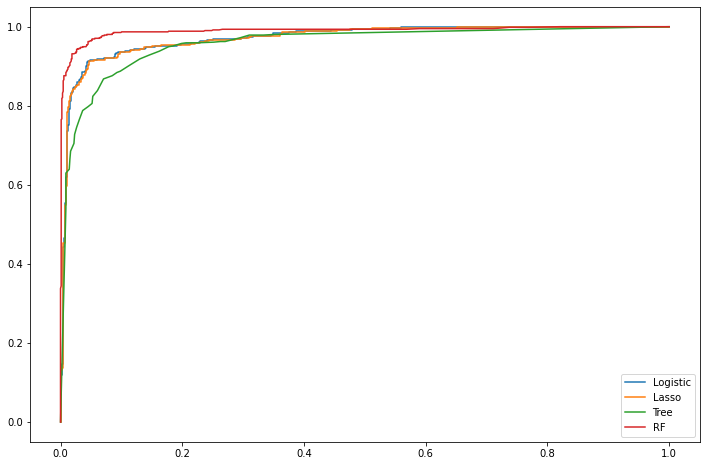

In [26]:
from sklearn.metrics import roc_curve

roc_logit = roc_curve(y_test,  lmfit.predict_proba(X_test)[:,1])
roc_lasso = roc_curve(y_test, lassofit.predict_proba(X_test)[:,1])
roc_tree = roc_curve(y_test, treefit.predict_proba(X_test)[:,1])
roc_rf = roc_curve(y_test, fitrf.predict_proba(X_test)[:,1])

line1, = plt.plot(roc_logit[0],roc_logit[1])
line2, = plt.plot(roc_lasso[0],roc_lasso[1])
line3, = plt.plot(roc_tree[0],roc_tree[1])
line4, = plt.plot(roc_rf[0],roc_rf[1])

plt.legend((line1,line2,line3,line4), ('Logistic','Lasso','Tree','RF'))
plt.show()

## How does it work?

scikit-learn returns the Gini feature importances (based on reduction of impurity at each split) for all the predictors:

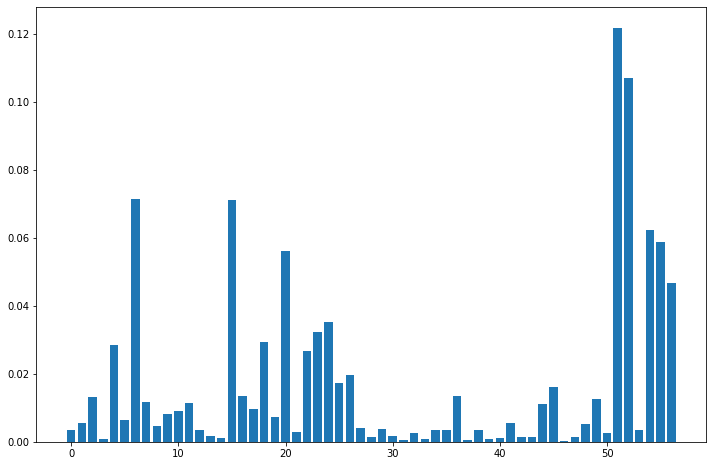

In [27]:
fitrf.feature_importances_
plt.bar(range(X.shape[1]), fitrf.feature_importances_)
plt.show()

We can match these up with the column names to see the importances in descending order (rounding just to make this easier to read):

In [90]:
a = list(zip(X_train.columns, np.around(fitrf.feature_importances_, 3)))
a.sort(key=lambda x: x[1], reverse=True)
a

[('char_freq_exc', 0.122),
 ('char_freq_dollar', 0.107),
 ('word_freq_remove', 0.071),
 ('word_freq_free', 0.071),
 ('capital_run_length_average', 0.062),
 ('capital_run_length_longest', 0.059),
 ('word_freq_your', 0.056),
 ('capital_run_length_total', 0.047),
 ('word_freq_hp', 0.035),
 ('word_freq_money', 0.032),
 ('word_freq_our', 0.029),
 ('word_freq_you', 0.029),
 ('word_freq_000', 0.027),
 ('word_freq_george', 0.02),
 ('word_freq_hpl', 0.017),
 ('word_freq_edu', 0.016),
 ('word_freq_1999', 0.014),
 ('word_freq_all', 0.013),
 ('word_freq_business', 0.013),
 ('word_freq_internet', 0.012),
 ('char_freq_paren', 0.012),
 ('word_freq_will', 0.011),
 ('word_freq_re', 0.011),
 ('word_freq_email', 0.01),
 ('word_freq_receive', 0.009),
 ('word_freq_mail', 0.008),
 ('word_freq_credit', 0.007),
 ('word_freq_address', 0.006),
 ('word_freq_over', 0.006),
 ('word_freq_meeting', 0.006),
 ('word_freq_order', 0.005),
 ('char_freq_semicol', 0.005),
 ('word_freq_650', 0.004),
 ('word_freq_labs', 0.00

Now let's make partial dependence plots. Here's one for the top-rated variable:

In [29]:
from pdpbox import pdp

In [30]:
pdpobj = pdp.pdp_isolate(fitrf, X_test, X_test.columns, 'char_freq_exc')

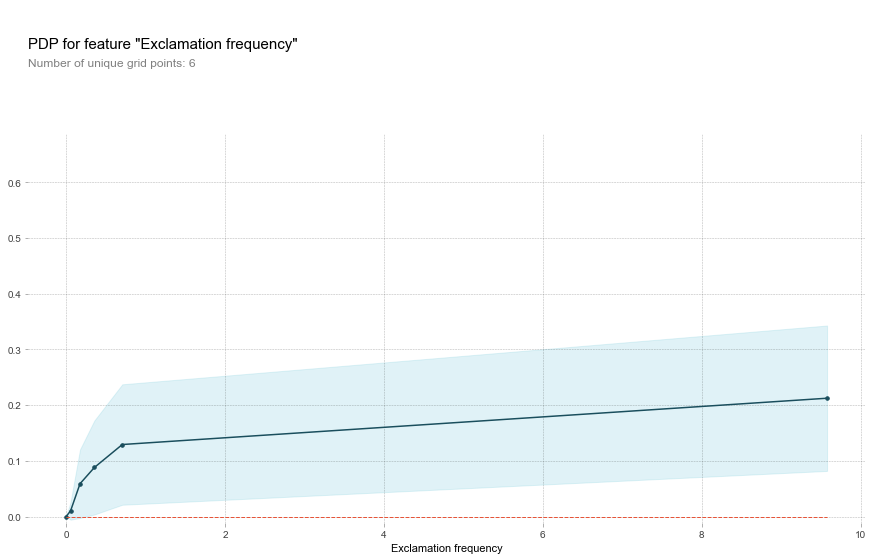

In [31]:
pdp.pdp_plot(pdpobj, 'Exclamation frequency')
plt.show()

# Or in R:

In [33]:
%%R -i X_train -i X_test -i y_train -i y_test

library(randomForest)

fitrf = randomForest(X_train, as.factor(y_train))
fitrf

R[write to console]: randomForest 4.6-14

R[write to console]: Type rfNews() to see new features/changes/bug fixes.




Call:
 randomForest(x = X_train, y = as.factor(y_train)) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 7

        OOB estimate of  error rate: 5.35%
Confusion matrix:
     0    1 class.error
0 1821   61  0.03241233
1  104 1096  0.08666667


In [34]:
%%R
mean(predict(fitrf, X_test)!= y_test)

[1] 0.04279131


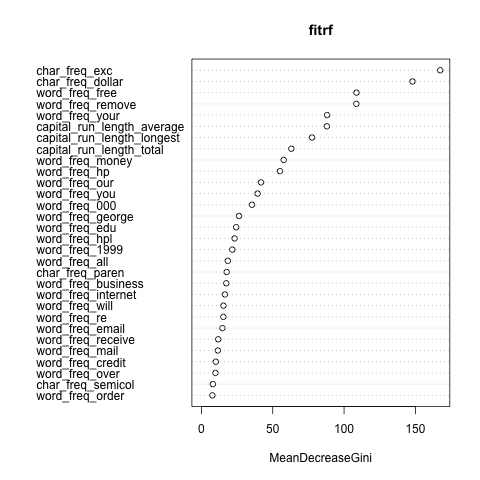

In [35]:
%%R
varImpPlot(fitrf)

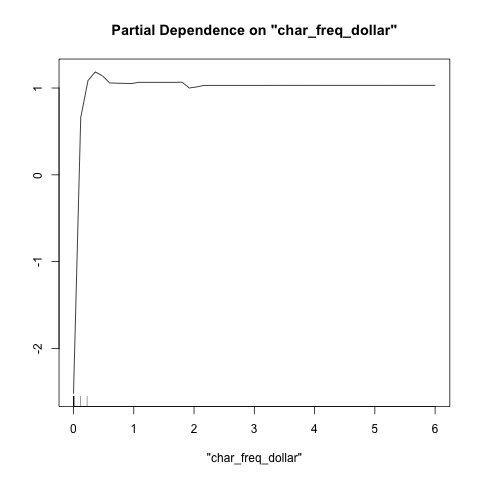

In [36]:
%%R
partialPlot(fitrf, X_train, x.var='char_freq_dollar', which.class=1)

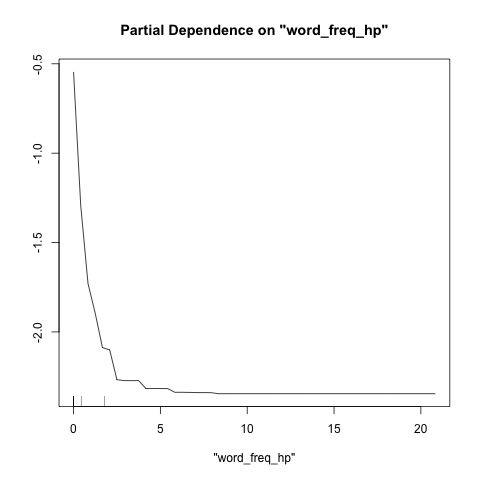

In [37]:
%%R
partialPlot(fitrf, X_train, x.var='word_freq_hp', which.class=1)

Here's the same plot we made in Python. Note that the Y axis doesn't match -- the two packages probably scale it differently. (The Y axis range is arbitrary; we can see in R that it's been set so the mean Y value is 0.)

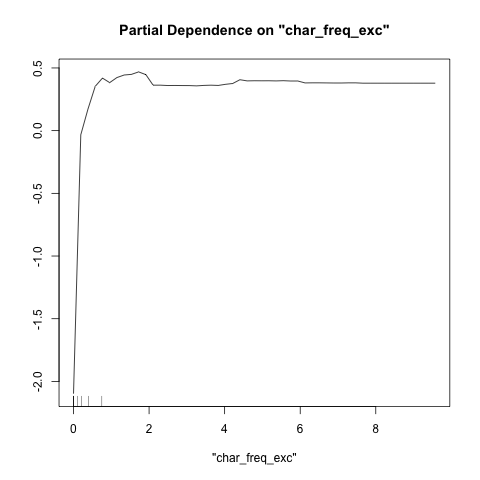

In [38]:
%%R
partialPlot(fitrf, X_test, x.var='char_freq_exc', which.class=1)

# Now let's look at boosting

In [40]:
import xgboost as xgb

In [41]:
# We are going to want to split our training data into a true training piece and a validation piece
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, test_size=0.33, random_state=1)

In [42]:
# xgboost uses its own matrix format (in all languages) so we need to cast our data.
# This can be done directly from a text file with xgb.DMatrix
# Here we will dump the values from the pandas objects
train_dm = xgb.DMatrix(X_train1.values, y_train1)
valid_dm = xgb.DMatrix(X_train2.values, y_train2)
test_dm = xgb.DMatrix(X_test.values, y_test)

In [45]:
# Set parameters for our boosted trees.  There are so many options.

param = {'max_depth': 6, # How deep should each tree be?
         'eta': 0.1, # The learning rate: how big are our steps?
         'verbosity': 0, # Whether to print out messages as you fit. 0 makes it quiet
         'objective': 'binary:logistic', # What is our loss function? For now, logistic. Would change for multiclass
         'gamma': 0, # Would make it harder to get splits in trees
         'subsample': 1, # How much to subsample for each tree. Smaller number (like 0.5) would subsample
         'colsample_bytree': 1, # like the random forest restriction on variables
         'lambda': 1, # How much L2 penalty on the node weights
         'alpha': 0,  # How much L1 penalty on the node weights
         'eval_metric': 'logloss',
         'seed': 1
        }
num_round = 100 # How many trees?

In [46]:
# Now we can train
bst = xgb.train(param, train_dm, num_round)

In [47]:
# And we can make predictions
preds = bst.predict(test_dm)

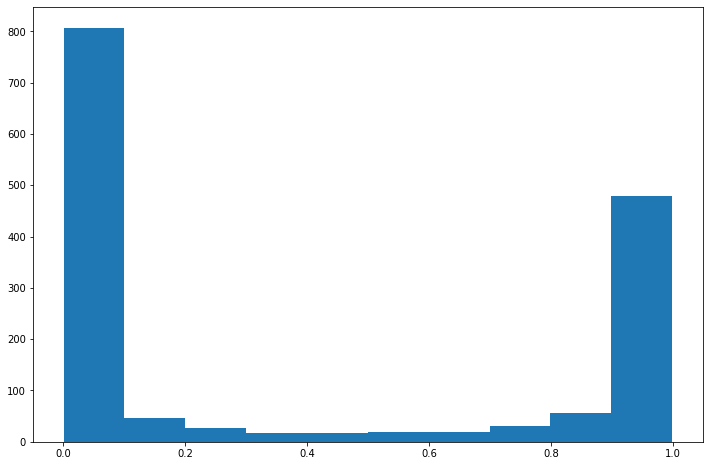

In [48]:
plt.hist(preds)
plt.show()

In [49]:
metrics.accuracy_score(y_test, preds > 0.5)

0.9545753785385122

## Let's think about tuning: What happens when number of trees is large?

In [50]:
# First, what happens to training error when the number of trees gets large?
preds = bst.predict(train_dm)
metrics.accuracy_score(y_train1, preds > 0.5)

0.9878875968992248

In [51]:
bst = xgb.train(param, train_dm, 1000) # MOAR TREES
preds = bst.predict(train_dm)
print(metrics.accuracy_score(y_train1, preds > 0.5))

preds = bst.predict(test_dm)
print(metrics.accuracy_score(y_test, preds > 0.5))

0.999515503875969
0.9519420671494404


In [52]:
cvres = xgb.cv(param, train_dm, 1000)

The results are presented as one CV-estimated error per boosting iteration. XGBoost calculates training and test errors, and their standard deviations:

In [92]:
cvres.head()

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
0,0.640273,0.001827,0.642970,0.001799
1,0.595387,0.002110,0.599816,0.000648
2,0.557425,0.002813,0.562820,0.001130
3,0.524324,0.002753,0.530616,0.001928
4,0.495445,0.002585,0.502994,0.001603


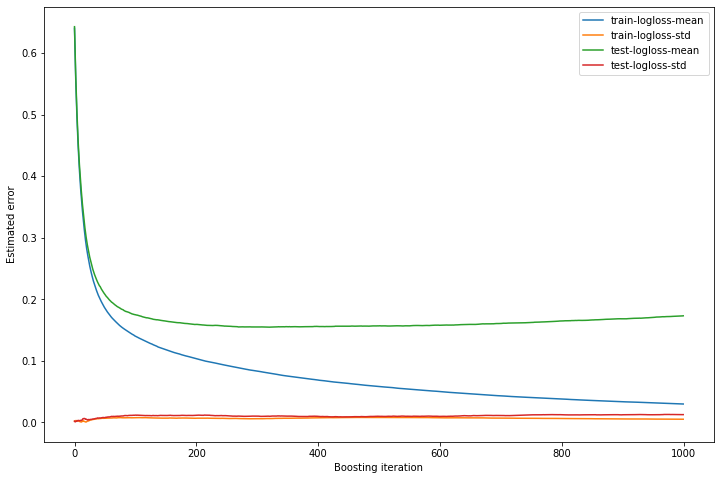

In [93]:
cvres.plot(xlabel = "Boosting iteration", ylabel = "Estimated error")
plt.show()

In [99]:
best_rounds = cvres['test-logloss-mean'].argmin()
best_rounds

319

In [100]:
bst = xgb.train(param, train_dm, best_rounds)
preds = bst.predict(train_dm)
print(metrics.accuracy_score(y_train1, preds>0.5))

preds = bst.predict(test_dm)
print(metrics.accuracy_score(y_test, preds>0.5))


0.999031007751938
0.955892034233048


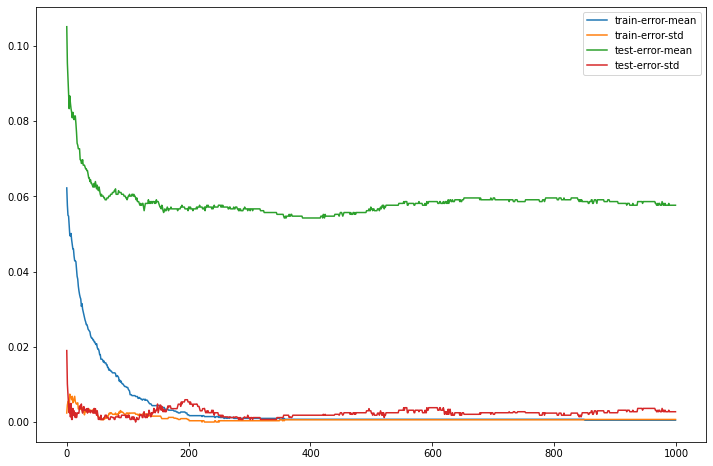

357

In [101]:
# We might be annoyed that the last was plotted in deviance.  We can change the error metric
param2 = param.copy()
param2['eval_metric'] = 'error'
cvres2 = xgb.cv(param2, train_dm, 1000)
cvres2.plot()
plt.show()
cvres2['test-error-mean'].argmin()

In [102]:
best_rounds2 = cvres2['test-error-mean'].argmin()

bst = xgb.train(param, train_dm, best_rounds2)
preds = bst.predict(train_dm)
print(metrics.accuracy_score(y_train1, preds>0.5))

preds = bst.predict(test_dm)
print(metrics.accuracy_score(y_test, preds>0.5))


0.999031007751938
0.9539170506912442


## Let's think about tuning: other parameters

Now you might search over other parameters.  The xgb.cv function doesn't do that.  However, there is an sklearn wrapper for xgboost, XGBClassifier, which lets you use GridSearchCV

In [59]:
from xgboost.sklearn import XGBClassifier

In [60]:
xgbc = XGBClassifier(
    max_depth=6, # How deep should each tree be?
    eta=0.1, # The learning rate: how big are our steps?
    silent=0, # Whether to print out messages as you fit. 1 makes it quiet
    objective='binary:logistic', # What is our loss function? For now, logistic. Would change for multiclas
    gamma=0, # Would make it harder to get splits in trees
    subsample=1, # How much to subsample for each tree. Smaller number (like 0.5) would subsample
    colsample_bytree=1, # like the random forest restriction on variables
    eval_metric='logloss',
    min_child_weight=1,
    seed=1,
    n_estimators = best_rounds
)
fitted = xgbc.fit(X_train1, y_train1)

In [61]:
metrics.accuracy_score(y_test, fitted.predict(X_test))

0.9552337063857801

In [62]:
from sklearn.model_selection import GridSearchCV 

In [103]:
param_grid1 = {
    'max_depth': range(2, 10, 2),
    'min_child_weight': range(1, 6, 2)
}

In [104]:
param_grid1

{'max_depth': range(2, 10, 2), 'min_child_weight': range(1, 6, 2)}

In [105]:
grid_search = GridSearchCV(estimator=xgbc, param_grid=param_grid1, 
                           scoring='roc_auc', cv=5).fit(X_train1, y_train1)

In [106]:
grid_search.cv_results_

{'mean_fit_time': array([0.31032119, 0.30472202, 0.28942542, 0.69322119, 0.5575274 ,
        0.45605717, 0.75420842, 0.76875439, 0.68046117, 0.92582259,
        0.81486936, 0.7042253 ]),
 'std_fit_time': array([0.0153831 , 0.02487053, 0.0263827 , 0.15296466, 0.06364357,
        0.02213472, 0.09821864, 0.19821856, 0.0610226 , 0.06791777,
        0.04497526, 0.02653126]),
 'mean_score_time': array([0.00500584, 0.00521636, 0.00456152, 0.00796299, 0.00499392,
        0.00479069, 0.00580397, 0.00591054, 0.00540781, 0.00559411,
        0.00589304, 0.00507345]),
 'std_score_time': array([0.00047961, 0.0007145 , 0.00036711, 0.00332348, 0.00038324,
        0.00012221, 0.00092376, 0.00110323, 0.00042735, 0.00055216,
        0.00129765, 0.00015477]),
 'param_max_depth': masked_array(data=[2, 2, 2, 4, 4, 4, 6, 6, 6, 8, 8, 8],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtype=object

In [107]:
xgbc = XGBClassifier(
    max_depth=2, # How deep should each tree be?
    eta=0.1, # The learning rate: how big are our steps?
    silent=0, # Whether to print out messages as you fit. 1 makes it quiet
    objective='binary:logistic', # What is our loss function? For now, logistic. Would change for multiclas
    gamma=0, # Would make it harder to get splits in trees
    subsample=1, # How much to subsample for each tree. Smaller number (like 0.5) would subsample
    colsample_bytree=1, # like the random forest restriction on variables
    eval_metric='logloss',
    seed=1,
    min_child_weight=1,
    n_estimators = best_rounds
)
fitted = xgbc.fit(X_train1, y_train1)
metrics.accuracy_score(y_test, fitted.predict(X_test))

0.955892034233048

In [109]:
param3 = param.copy()
param3['max_depth']=2
param3['min_child_weight']=1
cvres = xgb.cv(param3, train_dm, 1000)
best_rounds3 = cvres['test-logloss-mean'].argmin()


In [110]:
best_rounds3

319

In [111]:
bst = xgb.train(param3, train_dm, best_rounds3)
preds = bst.predict(train_dm)
print(metrics.accuracy_score(y_train1, preds>0.5))

preds = bst.predict(test_dm)
print(metrics.accuracy_score(y_test, preds>0.5))


0.9728682170542635
0.955892034233048


In [112]:
xgbc = XGBClassifier(
    max_depth=2, # How deep should each tree be?
    eta=0.1, # The learning rate: how big are our steps?
    silent=0, # Whether to print out messages as you fit. 1 makes it quiet
    objective='binary:logistic', # What is our loss function? For now, logistic. Would change for multiclas
    gamma=0, # Would make it harder to get splits in trees
    subsample=1, # How much to subsample for each tree. Smaller number (like 0.5) would subsample
    colsample_bytree=1, # like the random forest restriction on variables
    eval_metric='logloss',
    seed=1,
    min_child_weight=1,
    n_estimators = best_rounds3
)
fitted = xgbc.fit(X_train1, y_train1)
metrics.accuracy_score(y_test, fitted.predict(X_test))

0.955892034233048

We can then continue this pattern with other parameters, especially subsample sizes, eta, gamma, and maybe regularization

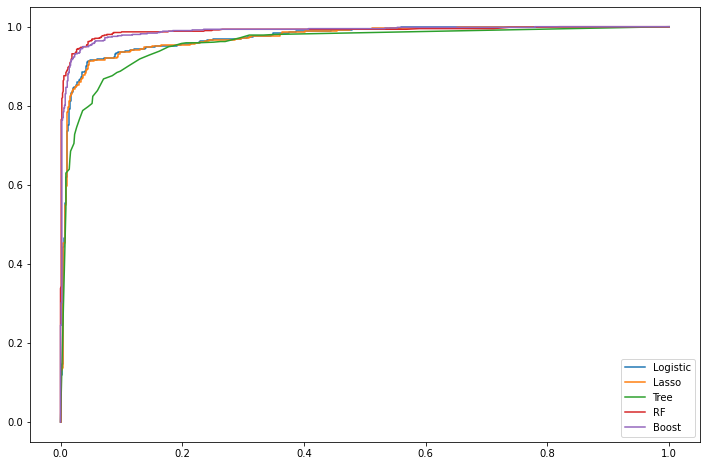

In [113]:
from sklearn.metrics import roc_curve

roc_logit = roc_curve(y_test,  lmfit.predict_proba(X_test)[:,1])
roc_lasso = roc_curve(y_test, lassofit.predict_proba(X_test)[:,1])
roc_tree = roc_curve(y_test, treefit.predict_proba(X_test)[:,1])
roc_rf = roc_curve(y_test, fitrf.predict_proba(X_test)[:,1])
roc_bst = roc_curve(y_test, fitted.predict_proba(X_test)[:,1])

line1, = plt.plot(roc_logit[0], roc_logit[1])
line2, = plt.plot(roc_lasso[0], roc_lasso[1])
line3, = plt.plot(roc_tree[0], roc_tree[1])
line4, = plt.plot(roc_rf[0], roc_rf[1])
line5, = plt.plot(roc_bst[0], roc_bst[1])

plt.legend((line1,line2,line3,line4,line5), ('Logistic','Lasso','Tree','RF','Boost'))
plt.show()

In [73]:
# Just as a warning, I did this
xgbc_tuned = XGBClassifier(
    max_depth=2, # How deep should each tree be?
    eta=0.1, # The learning rate: how big are our steps?
    silent=0, # Whether to print out messages as you fit. 1 makes it quiet
    objective='binary:logistic', # What is our loss function? For now, logistic. Would change for multiclas
    gamma=0.3, # Would make it harder to get splits in trees
    subsample=1, # How much to subsample for each tree. Smaller number (like 0.5) would subsample
    colsample_bytree=0.3, # like the random forest restriction on variables
    eval_metric='logloss',
    seed=1,
    min_child_weight=1,
    n_estimators = best_rounds3
)
fitted2 = xgbc_tuned.fit(X_train1, y_train1)
metrics.accuracy_score(y_test, fitted2.predict(X_test))

0.9545753785385122

In [74]:
# What happens on data we haven't been using?
metrics.accuracy_score(y_train2, fitted2.predict(X_train2))

0.9479371316306483

## Diagnostics for boosting

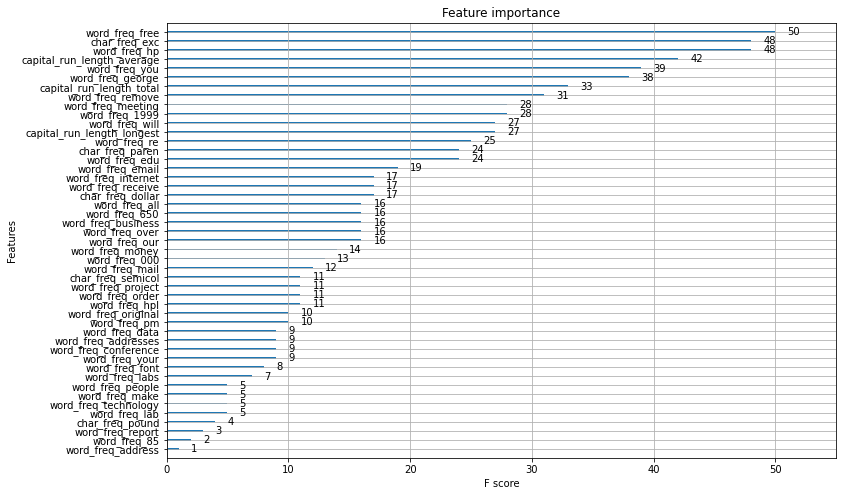

In [75]:
xgb.plot_importance(fitted)
plt.show()

In [76]:
from pdpbox import pdp

In [84]:
feature_names = [column for column in X_test.columns
                 if column != "spam"]
pdpobj = pdp.pdp_isolate(fitted, X_test, feature_names, 'char_freq_exc')

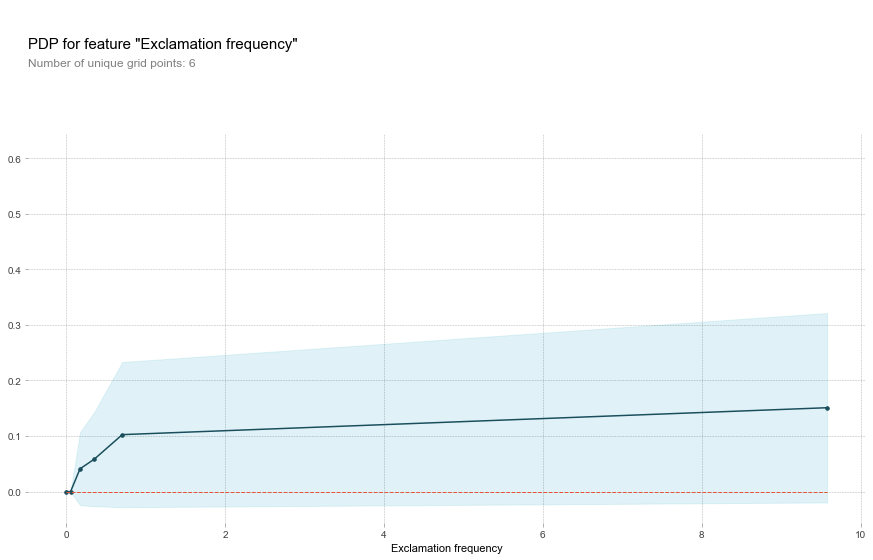

In [85]:
pdp.pdp_plot(pdpobj, 'Exclamation frequency')
plt.show()